# Selecting a location for a well for the company “GlavRosGosNeft”

Assuming we are working in the oil company "GlavRosGosNeft", we need to decide where to drill a new well. 
We have been provided with 10,000 oil samples from three regions, where the quality of the oil and the volume of its reserves were measured.

**Our Goal:** 
Build a machine learning model that will help determine the region where extraction will bring the highest profit. We will analyze possible profits and risks using the Bootstrap technique.

**Steps for Choosing a Location:**
- In the chosen region, we search for oil fields and determine the values of characteristics for each;
- Build a model to evaluate the volume of reserves;
- Choose oil fields with the highest rated values. The number of oil fields depends on the company's budget and the cost of developing one well;
- Profit is equal to the total profit from selected oil fields.

**Project Content:**

[Loading data](#Loading-data)\
[Data preprocessing and exploratory analysis](#Data-preprocessing-and-exploratory-analysis)\
[Model training and validation](#Model-training-and-validation)\
[Preparing for profit calculation](#Preparing-for-profit-calculation)\
[Profit and risk calculation](#Profit-and-risk-calculation)\
[General conclusion](#General-conclusion)

In [1]:
%%capture
!pip install --upgrade matplotlib seaborn scikit-learn scipy pandas shap

In [2]:
import numpy as np
print(np.__version__)

import shap
print(shap.__version__)

2.0.0



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/conda/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.9/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.9/site-packages/ipykernel/kerne

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/conda/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.9/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.9/site-packages/ipykernel/kerne

AttributeError: _ARRAY_API not found

0.46.0


In [ ]:
# import libraries before the project starts
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import stats as st
from IPython.display import display, Markdown

# load the pipeline class
from sklearn.pipeline import Pipeline

# load classes for data preparation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# import GridSearchCV
from sklearn.model_selection import GridSearchCV

# load the models
from sklearn.linear_model import LinearRegression

# load the function for working with metrics
from sklearn.metrics import r2_score, mean_squared_error


In [ ]:
# bring out the block with settings and functions

# set the dataframe settings before loading
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.3f}'.format)
pd.options.mode.chained_assignment = None # switch off warning after calling columns

try:
    pd.set_option('future.no_silent_downcasting', True)
except:
    pass

# print info about the dataframe
def get_info(dataset):
    display(dataset.info(), dataset.head(5), dataset.tail(5))


# printt histogram and boxplot
def hist_box(data,column,hue=None):
    
    palette = sns.color_palette('hsv', n_colors=10)
    random_color = random.choice(palette)
    
    if hue == None:
        
        fig, axes = plt.subplots(1, 2, figsize=(7, 2)) 
        ax = axes[0]
        sns.histplot(data=data, x=column, bins=10, 
                     color=random_color,
                     alpha=0.6,
                     legend='auto', ax=ax)
    else:
        fig, axes = plt.subplots(1, 2, figsize=(7, 2)) 
        ax = axes[0]
        sns.histplot(data=data, x=column, bins=10, 
                     color=random_color,
                     alpha=0.6,
                     hue=hue, 
                     multiple='stack',
                     legend='auto', ax=ax)
        

    ax = axes[1]
    sns.boxplot(x=data[column], color=random_color, ax=ax)
    ax.set_ylabel('')

    plt.tight_layout()
    plt.show();


<a id='Loading-data'></a>
## Loading data
[Back to Content](#To-content)

In [ ]:
# import datasets
try:
    geo_data_0 = pd.read_csv('/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_9_Neft/geo_data_0.csv')
    geo_data_1 = pd.read_csv('/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_9_Neft/geo_data_1.csv') 
    geo_data_2 = pd.read_csv('/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_9_Neft/geo_data_2.csv')
except:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')    

In [ ]:
# look at the data
get_info(geo_data_0)
get_info(geo_data_1)
get_info(geo_data_2);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,txEyH,0.706,-0.498,1.221,105.280
1,2acmU,1.335,-0.340,4.365,73.038
2,409Wp,1.023,0.152,1.420,85.266
3,iJLyR,-0.032,0.139,2.979,168.621
4,Xdl7t,1.988,0.155,4.752,154.037


,id,f0,f1,f2,product
99995,DLsed,0.972,0.371,6.075,110.744
99996,QKivN,1.392,-0.383,1.274,122.347
99997,3rnvd,1.030,0.019,-1.348,64.375
99998,7kl59,0.998,-0.529,1.584,74.041
99999,1CWhH,1.765,-0.266,5.723,149.633


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,kBEdx,-15.001,-8.276,-0.006,3.179
1,62mP7,14.272,-3.475,0.999,26.953
2,vyE1P,6.263,-5.948,5.001,134.766
3,KcrkZ,-13.081,-11.506,4.999,137.945
4,AHL4O,12.702,-8.147,5.004,134.766


,id,f0,f1,f2,product
99995,QywKC,9.536,-6.878,1.998,53.907
99996,ptvty,-10.161,-12.558,5.006,137.945
99997,09gWa,-7.379,-3.084,4.999,137.945
99998,rqwUm,0.666,-6.153,1.000,30.132
99999,relB0,-3.426,-7.794,-0.003,3.179


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,fwXo0,-1.147,0.963,-0.829,27.759
1,WJtFt,0.263,0.270,-2.530,56.070
2,ovLUW,0.195,0.289,-5.586,62.872
3,q6cA6,2.236,-0.554,0.930,114.573
4,WPMUX,-0.516,1.716,5.899,149.601


,id,f0,f1,f2,product
99995,4GxBu,-1.777,1.125,6.263,172.327
99996,YKFjq,-1.262,-0.895,2.525,138.749
99997,tKPY3,-1.200,-2.958,5.219,157.080
99998,nmxp2,-2.420,2.417,-5.548,51.795
99999,V9kWn,-2.551,-2.026,6.091,102.776


**Conclusion**

Based on the preliminary assessment of the loaded data, there is no need to correct column names or text values, nor is it necessary to convert data types for a convenient analysis. There are also no missing values, as indicated by the data types in the columns (float64) and the number of non-null data points of 100,000 records per dataset. Therefore, only duplicate checking and examination of distributions and outliers in the data should be performed to ensure accuracy before proceeding further.

<a id='Data-preprocessing-and-exploratory-analysis'></a>
## Data Preprocessing and Exploratory Analysis
[Back to Content](#To-content)

We will review and correct (if necessary) all comments from the previous section in turn:

In [ ]:
# check for duplicates in all three dataframes
display(geo_data_0.duplicated().sum(),
        geo_data_1.duplicated().sum(),
        geo_data_2.duplicated().sum())

np.int64(0)

np.int64(0)

np.int64(0)

,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,0.500,0.250,2.503,92.500
std,0.872,0.504,3.248,44.289
min,-1.409,-0.848,-12.088,0.000
25%,-0.073,-0.201,0.288,56.498
50%,0.502,0.250,2.516,91.850
75%,1.074,0.701,4.715,128.564
max,2.362,1.344,16.004,185.364


Распределение количественных переменных в датасете geo_data_0: 



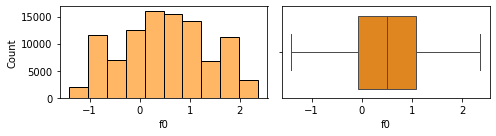

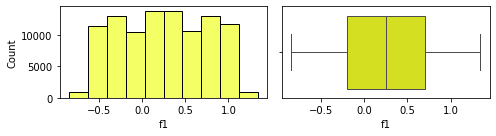

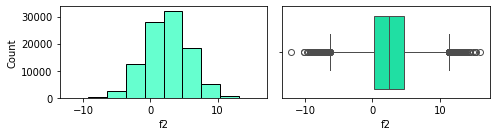

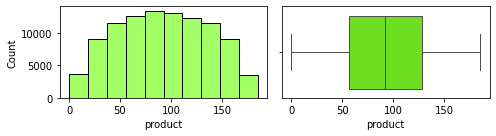

,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,1.141,-4.797,2.495,68.825
std,8.966,5.120,1.704,45.944
min,-31.610,-26.359,-0.018,0.000
25%,-6.299,-8.268,1.000,26.953
50%,1.153,-4.813,2.011,57.086
75%,8.621,-1.333,4.000,107.813
max,29.422,18.734,5.020,137.945


Распределение количественных переменных в датасете geo_data_1: 



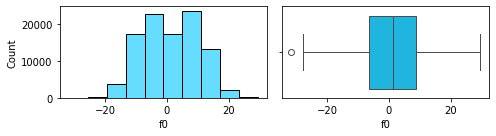

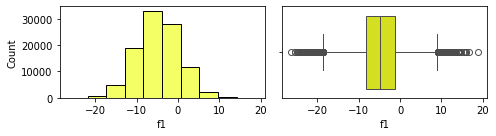

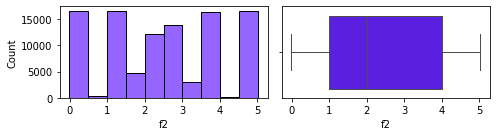

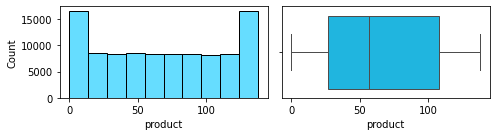

,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,0.002,-0.002,2.495,95.000
std,1.732,1.730,3.473,44.750
min,-8.760,-7.084,-11.970,0.000
25%,-1.162,-1.175,0.130,59.450
50%,0.009,-0.009,2.484,94.926
75%,1.159,1.164,4.859,130.595
max,7.238,7.845,16.739,190.030


Распределение количественных переменных в датасете geo_data_2: 



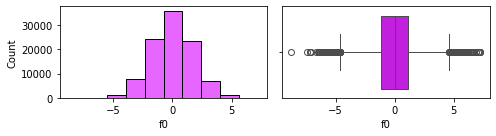

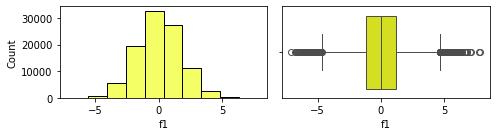

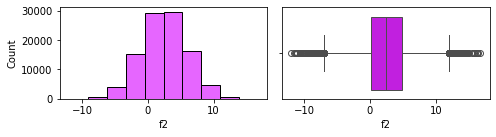

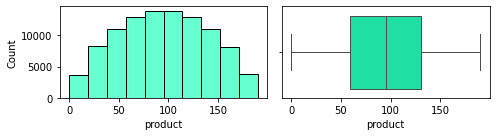

In [ ]:
# see the statistics and plot histograms and boxplots for quantitative variables for three datasets

datasets = [geo_data_0,geo_data_1,geo_data_2]
dataset_names = ['geo_data_0', 'geo_data_1', 'geo_data_2']
columns_num = ['f0', 'f1','f2','product']

for i,dataset in enumerate(datasets):
    display(dataset.describe())
    print(f'Distribution of quantitative Variables in the dataset {dataset_names[i]}: \n')
    
    for index, column in enumerate(columns_num):
        hist_box(dataset,column)

In [ ]:
# see the correlation of features in datasets
for i,dataset in enumerate(datasets):
    print(f'Correlation table of quantitative features in the dataset {dataset_names[i]}: \n')
    display(dataset.drop('id',axis=1).corr(method='spearman'))

Таблица корреляции количественных признаков в датасете geo_data_0: 



,f0,f1,f2,product
f0,1.000,-0.471,-0.003,0.128
f1,-0.471,1.000,0.001,-0.181
f2,-0.003,0.001,1.000,0.486
product,0.128,-0.181,0.486,1.000


Таблица корреляции количественных признаков в датасете geo_data_1: 



,f0,f1,f2,product
f0,1.000,0.182,-0.002,-0.123
f1,0.182,1.000,-0.004,-0.034
f2,-0.002,-0.004,1.000,0.976
product,-0.123,-0.034,0.976,1.000


Таблица корреляции количественных признаков в датасете geo_data_2: 



,f0,f1,f2,product
f0,1.000,0.002,0.000,-0.002
f1,0.002,1.000,0.000,-0.001
f2,0.000,0.000,1.000,0.448
product,-0.002,-0.001,0.448,1.000


**Conclusion**

No obvious duplicates were found in the data, and all input and target features are quantitative in all datasets. However, not all variables are distributed closely to normal, and outliers exist for specific features and datasets, likely reflecting the specificity of the considered geographic regions. Since the data is presented across varying ranges, it will be necessary to scale the data during preparation for training.

The Pearson correlation coefficients between the quantitative data and the target feature showed a significant relationship only between the target feature and the f2 feature (with values ranging from 0.44-0.48 for the zeroth and second regions, and an extremely strong connection with 0.98 for the first region), while the input features are almost uncorrelated with each other.

<a id='Model-training-and-validation'></a>
## Model training and validation
[Back to Content](#To-сontent)

Firstly, we will form training sets for the models on each of the three datasets. Then, we will create pipelines for data preparation and model training.

In [ ]:
# set the constants
RANDOM_STATE = 42
TEST_SIZE = 0.25

# form the sets of data for training and testing from the three existing datasets
X_train0, X_test0, y_train0, y_test0 = train_test_split(
    geo_data_0.drop(['id','product'], axis=1),
    geo_data_0['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    geo_data_1.drop(['id','product'], axis=1),
    geo_data_1['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    geo_data_2.drop(['id','product'], axis=1),
    geo_data_2['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

display(X_train0.head(),y_train0.head())
display(X_train1.head(),y_train1.head())
display(X_train2.head(),y_train2.head())


,f0,f1,f2
98980,1.612,-0.152,1.222
69824,-0.896,0.369,-4.538
9928,0.218,0.974,7.370
75599,0.883,0.669,3.115
95621,-0.942,0.634,2.874


98980   105.179
69824     9.351
9928    117.267
75599   116.538
95621   110.713
Name: product, dtype: float64

,f0,f1,f2
98980,9.296,-4.480,2.000
69824,15.837,1.953,4.989
9928,-1.595,-0.407,3.003
75599,12.336,-6.509,2.001
95621,-4.955,-8.026,1.001


98980    53.907
69824   134.766
9928     84.039
75599    53.907
95621    30.132
Name: product, dtype: float64

,f0,f1,f2
98980,-0.593,-2.323,5.345
69824,-0.691,1.716,-1.331
9928,1.742,-1.605,0.500
75599,-1.355,0.985,5.683
95621,1.075,1.175,1.010


98980   122.402
69824    43.300
9928    144.915
75599   114.039
95621    95.600
Name: product, dtype: float64

In [ ]:
# make lists with names of features for scaling input features
num_columns = ['f0','f1','f2']

# make pipeline for data preparation
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough',
    force_int_remainder_cols=False
)

In [ ]:
%%time

# make the final pipeline: data preparation and model
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

# set the grid of hyperparameters to be searched
param_grid = [

    # dictionary for LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]


# full grid search with 3 gridsearchers because gridsearchcv saves the state of the last training
grid_search_0 = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,

)

grid_search_1 = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,

)

grid_search_2 = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,

)

# train three models for each region
model_0 = grid_search_0.fit(X_train0, y_train0)
model_1 = grid_search_1.fit(X_train1, y_train1)
model_2 = grid_search_2.fit(X_train2, y_train2)

# get metric negMSE and convert to RMSE for each model
best_score_neg_mse_0 = model_0.best_score_
best_score_rmse_0 = round(float(np.sqrt(-best_score_neg_mse_0)),3)

best_score_neg_mse_1 = model_1.best_score_
best_score_rmse_1 = round(float(np.sqrt(-best_score_neg_mse_1)),3)

best_score_neg_mse_2 = model_2.best_score_
best_score_rmse_2 = round(float(np.sqrt(-best_score_neg_mse_2)),3)


CPU times: user 695 ms, sys: 267 ms, total: 962 ms
Wall time: 981 ms


In [ ]:
print(f'Metrics for best model with cross-validation for \033[1mzero\033[0m region: {best_score_rmse_0}')
# проверим работу модели на тестовой выборке
y_test_pred0 = model_0.predict(X_test0)
print(f'Metrics RMSE on test sample: {round(np.sqrt(mean_squared_error(y_test0, y_test_pred0)),3)}')
print(f'The average predicted reserve of the material: {np.mean(y_test_pred0)}\n') 

print(f'Metrics for best model with cross-validation for \033[1mfirst\033[0m региона: {best_score_rmse_1}')
# проверим работу модели на тестовой выборке
y_test_pred1 = model_1.predict(X_test1)
print(f'Metrics RMSE on test sample: {round(np.sqrt(mean_squared_error(y_test1, y_test_pred1)),3)}')
print(f'The average predicted reserve of the material: {np.mean(y_test_pred1)}\n') 

print(f'Metrics for best model with cross-validation for \033[1msecond\033[0m региона: {best_score_rmse_2}')
# проверим работу модели на тестовой выборке
y_test_pred2 = model_2.predict(X_test2)
print(f'Metrics RMSE on test sample: {round(np.sqrt(mean_squared_error(y_test2, y_test_pred2)),3)}')
print(f'The average predicted reserve of the material: {np.mean(y_test_pred2)}\n') 


Метрика лучшей модели с учетом кросс-валидации для нулевого региона: 37.673
Метрика RMSE на тестовой выборке: 37.757
Средний запас предсказанного сырья: 92.39879990657768

Метрика лучшей модели с учетом кросс-валидации для первого региона: 0.89
Метрика RMSE на тестовой выборке: 0.89
Средний запас предсказанного сырья: 68.71287803913762

Метрика лучшей модели с учетом кросс-валидации для второго региона: 40.027
Метрика RMSE на тестовой выборке: 40.146
Средний запас предсказанного сырья: 94.77102387765939



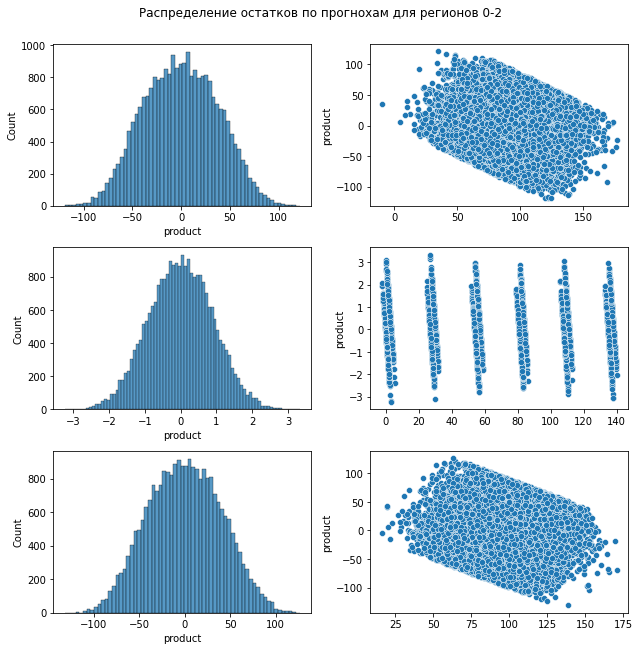

In [ ]:
# look at the residuals for all regions

y_test = [y_test0,y_test1,y_test2] 
y_test_pred = [y_test_pred0,y_test_pred1,y_test_pred2]

fig, axes = plt.subplots(3, 2, figsize=(9, 9));
fig.suptitle('The distribution of residuals for predictions by regions 0-2', y=1)

for i in range(0,3):
    ost = y_test[i] - y_test_pred[i]
    ax = axes[i][0]
    sns.histplot(data=ost,ax=ax)

    ax = axes[i][1]
    sns.scatterplot(x=y_test_pred[i], y=y_test[i] - y_test_pred[i],ax=ax);

plt.tight_layout();
plt.show();


**Conclusion**

Based on the results of training 3 models for each region, the metric for evaluating the effectiveness of prediction was chosen to be RMSE (due to the absence of significant outliers, this metric is relevant for assessing linear models). The average deviations for predictions in the 0th and 2nd regions were 37.7 thousand barrels and 40 thousand barrels, respectively, which corresponds to 40% and 42% of the average values of wells in these regions, respectively. These are relatively inaccurate predictions.

However, the model for the 1st region showed an average error of 0.9 thousand barrels, which is only 1.3% of the average value for wells in this region, which is much more accurate.

The analysis of residuals showed that they are distributed approximately normally, without a few peaks and outliers. The residual plots also show clear dependencies on predicted values, indicating that not all patterns were identified during training, and the residuals are not randomly distributed. This is likely due to the fact that the data was formed synthetically.

<a id='Preparing-for-profit-calculation'></a>
## Preparing for profit calculation
[Back to Content](#To-content)

In [ ]:
# save data for calculation of profit
BUDGET = 10_000_000_000 # the budget for development of the region
REVENUE_1P = 450_000 # revenue generated from one unit of product
WELL_COUNT = 200

product_0 = geo_data_0['product']
product_1 = geo_data_1['product']
product_2 = geo_data_2['product']

# save the forecasts of the reserves for the models
product_probs_0 = pd.Series(model_0.predict(geo_data_0.drop(['id','product'],axis=1)))
product_probs_1 = pd.Series(model_1.predict(geo_data_1.drop(['id','product'],axis=1)))
product_probs_2 = pd.Series(model_2.predict(geo_data_2.drop(['id','product'],axis=1)))

# calculate the minimum volume of oil required for the profitable development of a new well
payback_volume = BUDGET / WELL_COUNT / REVENUE_1P
print(f'The minimum oil reserve required for the break-even point development of a well, measured in thousand barrels: {payback_volume:.3f}')

# compare the obtained volume of raw materials with the average reserve in each region
print(f'The average reserves across all wells in the zeroth region: {product_0.sum()/len(product_0):.3f} thousands of barrels.')
print(f'The average reserves across all wells in the first region.: {product_1.sum()/len(product_1):.3f} thousands of barrels.')
print(f'The average reserves across all wells in the second region.: {product_2.sum()/len(product_2):.3f} thousands of  barrels.')

Минимальный запас нефти, необходимый для окупаемости разработки скважины, составляет в тыс. баррелей: 111.111
Средние запасы по всем скважинам нулевого региона: 92.500 тыс. баррелей.
Средние запасы по всем скважинам первого региона: 68.825 тыс. баррелей.
Средние запасы по всем скважинам второго региона: 95.000 тыс. баррелей.


**Conclusion**

Based on preliminary calculations, the minimum oil reserves in a well required for its development to be profitable at current prices is 111.11 thousand barrels.

Comparing the average values of reserves across all wells in each of the three regions (92.5, 68.8, and 95.0 thousand barrels, respectively), it can be assumed that developing any existing wells on average is not economically viable and selection should be based on evaluating potential reserves exceeding the break-even point.

It's also worth considering that the existing wells may have been developed under different circumstances and oil prices, so they may have already reached profitability at current market conditions. However, when predicting and selecting new wells for development, it's essential to consider average reserve values by region.

<a id='Profit-and-Risk Calculation'></a>
## Profit and Risk Calculation
[Back to Content](#To-content)

In [ ]:
# prepare function for profit calculation from predicted data
def profit(product, product_prob, revenue_1p,count):
    product_prob = pd.Series(product_prob)
    probs_sorted = product_prob.sort_values(ascending=False)
    profit = float(round(product[probs_sorted.index][:count].sum()*revenue_1p - BUDGET,2))
    return profit


In [ ]:
state = np.random.RandomState(1)
product_regions = [product_0,product_1,product_2]
product_probs = [product_probs_0,product_probs_1,product_probs_2]
region_names = ['регион_0','регион_1','регион_2']

for j,product_region in enumerate(product_regions):
    profits = []

    for i in range(1000):
        product_subsample = product_region.sample(frac=500/len(product_region),replace=True,random_state=state)
        probs_subsample = product_probs[j][product_subsample.index] 
        profits.append(profit(product_subsample,probs_subsample, REVENUE_1P,200))

    profits = pd.Series(profits)
    mean = round(profits.mean(),2)
    print(f'Average profit for region {region_names[j]}: {mean:,.2F}')
    
    # calculate the 95% confidence interval for the average profit for each region
    lower = profits.quantile(0.025)
    higher = profits.quantile(0.975)
    print(f'95% confidence interval for the average profit for region {region_names[j]}:\
          {lower:,.2F}, {higher:,.2F}')
    
    # calculate the probability of losses for each region based on the available data on the stocks
    print(f'Probability to get loss in region {region_names[j]} is : {(profits < 0).mean() *100:.2f}% \n')


Средняя прибыль региона регион_0: 417,608,401.22
95%-ый доверительный интервал для средней выручки региона регион_0:          -85,643,956.24, 932,570,436.25
Вероятность получения убытков в регион_0: 6.10% 

Средняя прибыль региона регион_1: 468,259,100.42
95%-ый доверительный интервал для средней выручки региона регион_1:          99,520,638.16, 857,265,440.51
Вероятность получения убытков в регион_1: 1.00% 

Средняя прибыль региона регион_2: 369,479,410.42
95%-ый доверительный интервал для средней выручки региона регион_2:          -162,946,518.52, 880,826,233.62
Вероятность получения убытков в регион_2: 8.50% 



**Conclusion**

Based on the results of constructing a distribution of average profit using the bootstrap method, we obtained estimates of the average profit for each region at levels of 417.7 million rubles, 468.3 million rubles, and 369.5 million rubles for regions 0 to 2, respectively.

The 95% confidence intervals were (-85.6, 932.6), (99.5, 857.3), and (-162.9, 880.8) for the corresponding regions.

Additionally, we estimated the probability of incurring losses for each region: 6.1%, 1.0%, and 8.5% respectively.

Therefore, we see that the lowest risk of incurring losses is associated with region_1, which also has the highest average predicted profit. Therefore, we recommend paying attention to the development of **region_1** (second in the overall list) as the most promising in terms of minimizing risks and profitability of selecting 500 wells and developing the 200 best ones.

<a id='General-Conclusion'></a>
## General Conclusion
[Back to Content](#To-content)

In this project, the objective was to analyze oil sample data from **three regions (0,1,2)** and use the provided data to train three models to predict reserves in each region. Next, we assessed the profitability distribution for each region, taking into account specified price conditions and field selection criteria, ultimately recommending the most profitable region for initial development.

**Data Preprocessing and Initial Assessment:**

Upon preliminary review, the data did not require significant adjustments; checks for duplicates, outliers, and anomalies were performed. No duplicate entries were found, and all input and target features across datasets were quantitative. Not all were close to a normal distribution, with some outliers observed in certain features and datasets, likely reflecting the unique characteristics of the specific geographical regions. Since data ranges varied, scaling was necessary during preparation for model training. Spearman correlation coefficients between quantitative data and the target feature indicated a strong correlation only with feature f2 (for regions 0 and 2, around 0.44–0.48; and for region 1, a very strong correlation at 0.98). The input features showed minimal inter-correlation.

**Model Training and Evaluation:**

After training three models for each region, we chose RMSE as the metric for evaluating prediction accuracy (since the absence of significant outliers makes RMSE suitable for assessing linear models). The RMSE for predictions in regions 0 and 2 was approximately 37.7k and 40k barrels, respectively, amounting to 40% and 42% of the average well values in these regions, indicating relatively low prediction accuracy. The model for region 1, however, yielded a mean error of 0.9k barrels, which represents 1.3% of the regional average, reflecting significantly higher accuracy.

Residual analysis showed approximate normal distribution without major peaks or outliers. Scatterplots of residuals, however, revealed noticeable dependencies on predicted values, suggesting that not all patterns were captured during training. This likely reflects the synthetic nature of the dataset.

**Break-even Analysis:**

Our preliminary calculations showed a minimum reserve requirement of 111.11k barrels per well for development to break even at current prices. When comparing the mean reserves across wells in each of the three regions (92.5, 68.8, and 95.0k barrels, respectively), it appears that developing all available wells would generally be unprofitable, and **targeted selection** based on reserves above the break-even threshold is necessary.

It's worth noting that existing wells may have been developed under different market conditions and prices, and may already be profitable. However, when selecting new wells for development, average reserves by region should be factored in.

**Profit Calculation and Bootstrapping Results:**

A profit calculation function was created for the final project stage, applied in a 1,000-sample bootstrap process for selecting 500 wells, then evaluating the top 200 for profitability in each region. Based on bootstrap profit distributions, we obtained average profit estimates per region of approximately 417.7, 468.3, and 369.5 million rubles for regions 0 to 2, respectively. The 95% confidence intervals were (-85.6, 932.6), (99.5, 857.3), and (-162.9, 880.8), respectively, with estimated loss probabilities of 6.1%, 1.0%, and 8.5%.

**Conclusion:**

Region 1 demonstrates the lowest risk of losses, as well as the highest average forecasted profit. Therefore, we recommend **Region 1** (second on the overall list) as the most promising option in terms of minimizing risk and maximizing profitability by selecting 500 wells and developing the top 200.